In [1]:
import pickle
import pandas as pd
import numpy as np

import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import datetime as datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar
%matplotlib inline

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#unpickle
df = pd.read_pickle("./preprocessed.pkl")

In [3]:
df.sort_values('date')

,date,tokenized
66,2018-11-01,audio network appointed todd king west coast k...
65,2018-11-01,big deal publishing group signed deal represen...
64,2018-11-01,youtube global head lyor cohen called implicat...
63,2018-11-01,global acquired digital audio sales division c...
62,2018-11-01,six months time fun games begin anew understan...
...,...,...
4,2020-03-02,warner group ipo supposed start kicking week c...
3,2020-03-02,amuse fast become recognizable names independe...
2,2020-03-03,independent record company glassnote hired dex...
0,2020-03-03,ralph simon child johannesburg mother gave adv...


### TF-IDF

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [5]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.4, min_df = 15
                                   ) #how is this filtering out extremes
tfidf = tfidf_vectorizer.fit_transform(df['tokenized'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
nmf = NMF(n_components = 30, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)

In [6]:
#copying code
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [7]:
transformed_data = nmf.transform(tfidf)
len(transformed_data)

2244

In [8]:
print_top_words(nmf, tfidf_feature_names, 20)
# more key words and easier to interpret topics 

Topic #0:
platform streaming service rights services million digital data content creators audio licensing users amazon distribution publishers ceo independent technology royalties
Topic #1:
spotify india users premium month service streaming subscribers free head mccarthy paying spot daniel price crb playlists app launch playlist
Topic #2:
people really going think lot get want got would know things something always thing way good much make great work
Topic #3:
sony yen corp japan calendar entertainment emi publishing stringer fiscal quarterly recorded currency division emp universal posted prevailing revenues rob
Topic #4:
revenues streaming revenue recorded total sales growth market grew physical quarter annual according billion generated paid services riaa last record
Topic #5:
album publishing songwriter chart top released songs albums deal hit debut single platinum umpg band producer signed awards singer grammy
Topic #6:
directive european copyright article text parliament creato

In [9]:
topic_num_to_name = {1: "Spotify India", 
                     2: "People & work", 
                     3: "labels & revenue",
                     4: "streaming revenue",
                     5: "chart toppers", 
                     6: "European copyright laws" ,
                     7: "corporate promotions", 
                     8: "soundcloud",
                     9: "corporate promotions 2",
                     10: "publishing",
                     11: "pandora, siriusxm",
                     12: "labels",
                     13: "corporate promotions 3",
                     14: "awal & kobalt deal",
                     15: "african music",
                     16: "youtube",
                     17: "social media",
                     18: "podcasts",
                     19: "labels 2",
                     20: "apple, amazon, google, streaming",
                     21: "hipgnosis",
                     22: "tencent",
                     23: "radio",
                     24: "tiktok",
                     25: "publishing rights",
                     26: "touring",
                     27: "live nation",
                     28: "corporate promotions 4",
                     29: "Latin America"}

### create long form dataset

don't really understand this completely. just trying to see if it works for now

In [10]:
data = df['date']
count_df = pd.DataFrame(data, columns = ['date'])
count_df['articles'] = df['tokenized']
count_df['article_index'] = count_df.articles.index

In [11]:
### extract month-year info from 'date' column
ser1 = pd.Series(count_df['date']) 
new = count_df['date'].str.split("-", n =2 , expand = True)
count_df['year']= new[0]  
count_df['month']= new[1]  

In [12]:
count_df.head()

,date,articles,article_index,year,month
0,2020-02-28,recent rainy night manhattan kelsea ballerini ...,0,2020,02
1,2020-02-22,forget minute two men thought sang milli vanil...,1,2020,02
2,2020-02-19,editors note ongoing series explore best buzzw...,2,2020,02
3,2020-01-24,continues grow change decided time annual powe...,3,2020,01
4,2019-12-12,desiree perez coo roc nation typical day desir...,4,2019,12


In [13]:
df_groupby_year_month = count_df.groupby(['year','month'])

In [14]:
df_groupby_year_month.count()

date  articles  article_index
year month                               
2018 11      133       133            133
     12      114       114            114
2019 01      196       196            196
     02      164       164            164
     03      168       168            168
     04      173       173            173
     05      179       179            179
     06      167       167            167
     07      171       171            171
     08      131       131            131
     09      139       139            139
     10      142       142            142
     11      116       116            116
     12      113       113            113
2020 01        4         4              4
     02      126       126            126
     03        8         8              8

In [15]:
count_df['new_date'] = pd.to_datetime(count_df['date']).apply(lambda x:x.strftime('%Y-%m')) # Convert to DateTime and group by month 

In [16]:
def zero_equals_1(x): 
    if x != 0:
        return 1
    else:
        return x

In [17]:
transformed_data = pd.DataFrame(transformed_data)
article_topics = transformed_data.applymap(zero_equals_1)

In [18]:
count_df = count_df.reset_index()

In [19]:
article_topics["Date"] = count_df["new_date"]

In [20]:
article_topics["Article_Num"] = range(1, len(article_topics) + 1)

In [21]:
article_topics.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,Date,Article_Num
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-02,1
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-02,2
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2020-02,3
3,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,2020-01,4
4,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2019-12,5


In [22]:
#create melted_df
melted_df = pd.melt(article_topics, id_vars = ["Article_Num", "Date"], var_name = "Topic_Num")

In [23]:
melted_df

,Article_Num,Date,Topic_Num,value
0,1,2020-02,0,1.0
1,2,2020-02,0,0.0
2,3,2020-02,0,1.0
3,4,2020-01,0,1.0
4,5,2019-12,0,1.0
...,...,...,...,...
67315,2240,2019-12,29,0.0
67316,2241,2019-12,29,1.0
67317,2242,2019-12,29,0.0
67318,2243,2019-12,29,0.0


In [24]:
melted_df.groupby("Topic_Num").sum().sort_values("value").reset_index()

,Topic_Num,Article_Num,value
0,28,2518890,41.0
1,26,2518890,71.0
2,15,2518890,81.0
3,8,2518890,93.0
4,24,2518890,101.0
5,14,2518890,129.0
6,13,2518890,129.0
7,11,2518890,145.0
8,22,2518890,151.0
9,21,2518890,167.0


In [25]:
topic_num_to_name = pd.DataFrame.from_dict(topic_num_to_name, orient = "index").reset_index()
topic_num_to_name.columns = ["Topic_Num", "Topic_Name"]
final_df = melted_df.merge(topic_num_to_name, on = "Topic_Num")

In [26]:
final_df.head(50)

,Article_Num,Date,Topic_Num,value,Topic_Name
0,1,2020-02,1,0.0,Spotify India
1,2,2020-02,1,0.0,Spotify India
2,3,2020-02,1,0.0,Spotify India
3,4,2020-01,1,1.0,Spotify India
4,5,2019-12,1,0.0,Spotify India
5,6,2019-11,1,1.0,Spotify India
6,7,2019-11,1,1.0,Spotify India
7,8,2019-10,1,0.0,Spotify India
8,9,2019-10,1,0.0,Spotify India
9,10,2019-09,1,1.0,Spotify India


In [45]:
final_df.groupby('Date')

In [49]:
#putting topics into groups 
overall_topics = pd.DataFrame({"Streaming": [1, 4, 8, 11, 16, 20, 18], 
                               "Chinese Music Companies": [22, 24,"NaN", "NaN", "NaN", "NaN", "NaN" ], 
                              "Copyrights & Publishing": [6,10,25, "NaN", "NaN", "NaN", "NaN"]})
                               #"Other": [16, 19, 20, 26, 27, 29, "NaN", "NaN", "NaN", "NaN"]

In [56]:
melted_ot = pd.melt(overall_topics)
melted_ot = melted_ot[melted_ot["value"] != "NaN"]
melted_ot.columns = ["Overall Topic", "Topic_Num"]

In [57]:
final_df = final_df.merge(melted_ot, on = "Topic_Num")

In [59]:
order = ['2018-11','2018-12', '2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

[Text(0, 0.5, 'Number of Articles'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Articles')]

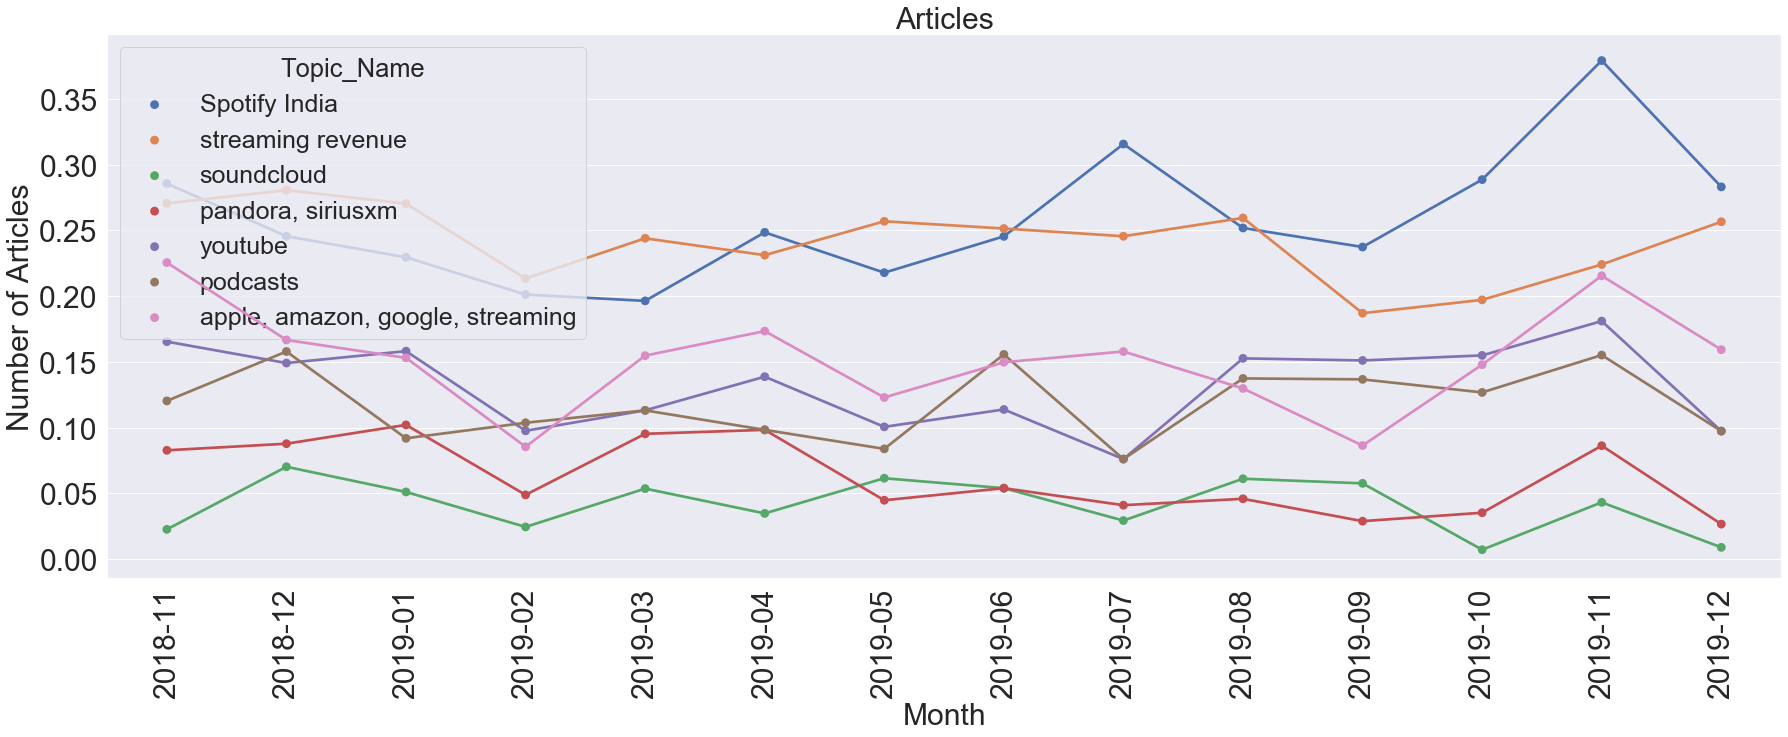

In [61]:
rc={'xtick.labelsize': 30, 'ytick.labelsize': 30, 'axes.labelsize': 30, 'font.size': 30, 'legend.fontsize': 25.0, 'axes.titlesize': 30, "figure.figsize": [30, 10]}
sns.set(rc=rc)
one_topic = final_df[final_df["Overall Topic"] == "Streaming"]
g = sns.pointplot(ci = None, x = one_topic["Date"], y = one_topic["value"], order = order, hue = one_topic["Topic_Name"])
plt.xticks(rotation=90)
g.set(xlabel = "Month", ylabel = "Number of Articles", title = "Articles")
#plt.savefig("Policy_Articles.png", bbox_inches='tight')